In [8]:
# import necessary libraries
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv('df_merged_weekly_all.csv', index_col=0)
data['date'] = pd.to_datetime(data['date'])
data.head()

,index,week,date,cases,temperature,pressure,humidity,precipitation
0,0,2016-1,2016-01-10,19.0,303.437143,1012.285714,71.428571,1.02
1,1,2016-2,2016-01-17,23.0,303.908571,1012.857143,65.571429,0.00
2,2,2016-3,2016-01-24,31.0,302.251429,1014.428571,76.857143,32.85
3,3,2016-4,2016-01-31,26.0,302.778571,1011.142857,75.142857,17.05
4,4,2016-5,2016-02-07,10.0,303.285714,1012.428571,70.571429,3.70


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          398 non-null    int64         
 1   week           398 non-null    object        
 2   date           398 non-null    datetime64[ns]
 3   cases          398 non-null    float64       
 4   temperature    398 non-null    float64       
 5   pressure       398 non-null    float64       
 6   humidity       398 non-null    float64       
 7   precipitation  398 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 28.0+ KB


# Columns
| column        | description                             | type     |
|---------------|-----------------------------------------|----------|
| week          | week corresponding to the specific year | datetime | 
| dt            | specific date                           | datetime |
| Cases         | Dengue Cases                            | integer  |
| temp          | Average temperature in the given week   | numeric  |
| feels_like    | Average feels_life in the given week    | numeric  |
| pressure      | Average pressure in the given week      | numeric  |
| humidity      | Average humidity in the given week      | numeric  |
| precipitation | Total precipitation in the given week   | numeric  |

## Training data
Data used to be trained range from 2022 to 2023

## Testing data
Data used to be tested is 2024 (also used for training)

In [11]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
standard_scaler = MinMaxScaler()
features = ["temperature", "humidity", "precipitation"]
X = data[features]
X = standard_scaler.fit_transform(X)
temp = X[:,0]
humidity = X[:,1]
precipitation = X[:,2]
data['temperature'] = temp
data['precipitation'] = precipitation
data['humidity'] = humidity

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

class Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropouts):
        super().__init__()
        if hidden_sizes is None:
            hidden_sizes = [48, 32, 19]
        layers = [] # initialize layers
        layers.append(nn.Linear(input_size, hidden_sizes[0])) # first layer
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1])) # append each hidden layer
        self.layers = nn.ModuleList(layers) # read more about module lists for pytorch
        self.output = nn.Linear(hidden_sizes[len(hidden_sizes)-1], output_size)
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for dropout in dropouts])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layers[0](x))
        x = self.dropouts[0](x)
        x = self.relu(self.layers[1](x))
        x = self.dropouts[1](x)
        x = self.relu(self.layers[2](x))
        x = self.dropouts[2](x)
        x = self.output(x)
        return x

def train_ANN(data, features, target, date_col, n_ahead, year_test_start,year_test_end):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU
    # Select relevant columns
    rel_col = features + [target] + [date_col]
    data = data[rel_col]

    # Getting the first and last index for the testing years
    first_test = data[data[date_col].dt.year == year_test_start].index[0]
    last_test = data[data[date_col].dt.year == year_test_end].index[-1]

    first_testsubn = first_test - n_ahead
    last_testsubn = last_test - n_ahead

    # Define lags
    env_lags = [1,2,3,4]  # 2-week lag for environment features
    cases_lag = range(1, 12)  # 1 to 11 week lags for target variable

    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)

    # Remove any rows with missing values due to lagging
    data = data.dropna()

    # Initialize list for storing predictions
    predict_data = []
    actual_data = []
    # Loop through data to get n-week ahead prediction
    index_begin = first_testsubn
    index_end = last_testsubn
    loss_ave = 0
    while index_begin <= index_end:
        i = 0
        # Split data into training and testing sets
        train_data = data[data.index <= index_begin]
        test_data = data.iloc[data.index.get_loc(index_begin):data.index.get_loc(index_begin) + n_ahead]

        X_train = train_data.drop(columns=[target, date_col])
        y_train = train_data[target]
        X_test = test_data.drop(columns=[target, date_col])
        y_test = test_data[target]

        # Convert to PyTorch tensors
        X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

        # Combine inputs and labels into a Dataset
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

        # Initialize the ANN Model
        input_size = X_train.shape[1]
        hidden_sizes = [48, 32, 18]
        dropouts = [0.3, 0.2, 0.1]
        output_size = 1  
        model = Model(input_size, hidden_sizes, output_size, dropouts)
        model.to(device)

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()
        loss_history = []
        # Train the model
        model.train()
        num_epochs = 100
        for epoch in range(num_epochs):
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
        
                # Get model predictions (assuming output size is n_ahead)
                predictions = model(batch_X)
                
                # Compute loss (MSE)
                loss = loss_fn(predictions.squeeze(), batch_y)
                loss_history.append(loss.item())
                # Backpropagation
                loss.backward()
                optimizer.step()
            #print(f'Epoch {epoch+1}/{num_epochs} has passed')

        #  Evaluate on test data
        model.eval()
        with torch.no_grad():
            predictions = model(X_test).squeeze().cpu().numpy()
            actual_y = y_test.cpu().numpy()
        try:
            predictions = predictions[-1]
        except IndexError:
            pass
        predict_data.append(predictions)
        actual_data.append(actual_y[-1])
        index_begin += 1
        print(sum(loss))
    # Calculate Mean Absolute Error
    MAE = mean_absolute_error(actual_data, predict_data)
    MSE = mean_squared_error(actual_data, predict_data)
    return predict_data, MAE, MSE


In [36]:
# Perform Initial Testing
target="cases"
features=["temperature","humidity","precipitation"]
date = 'date'
year_test_start = 2023
year_test_end = 2024
prediction_1_week, MAE_1_week, MSE_1_week = train_ANN(data, features, target, date, 1, year_test_start, year_test_end)
prediction_4_week, MAE_4_week, MSE_4_week= train_ANN(data, features, target, date, 4, year_test_start, year_test_end)

/tmp/ipykernel_33290/3026266706.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/tmp/ipykernel_33290/3026266706.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). 

In [37]:
print(f'The Mean Absolute Error of the 1-Week Ahead Model is {MAE_1_week}')
print(f'The Mean Absolute Error of the 4-Week Ahead Model is {MAE_4_week}')
print(f'The Root Mean Squared Error of the 1-Week Ahead Model is {np.sqrt(MSE_1_week)}')
print(f'The Root Mean Squared Error of the 4-Week Ahead Model is {np.sqrt(MSE_4_week)}')

The Mean Absolute Error of the 1-Week Ahead Model is 8.038046836853027
The Mean Absolute Error of the 4-Week Ahead Model is 8.786066055297852
The Root Mean Squared Error of the 1-Week Ahead Model is 14.159079551696777
The Root Mean Squared Error of the 4-Week Ahead Model is 14.583754539489746


In [8]:
prediction_1_week[:5]

[array(16.9477, dtype=float32),
 array(13.450987, dtype=float32),
 array(11.027606, dtype=float32),
 array(13.345202, dtype=float32),
 array(15.411059, dtype=float32)]

In [9]:
prediction_4_week[:5]

[np.float32(25.56216),
 np.float32(15.24588),
 np.float32(12.771307),
 np.float32(12.398629),
 np.float32(11.084826)]

# Visualization

In [40]:
import matplotlib.pyplot as plt
first_2024 = int((data['date'].dt.year==2023).idxmax())
last_2024 = int(data.loc[data['date'].dt.year == 2024].index[-1])
date = data.loc[first_2024:last_2024]['date']

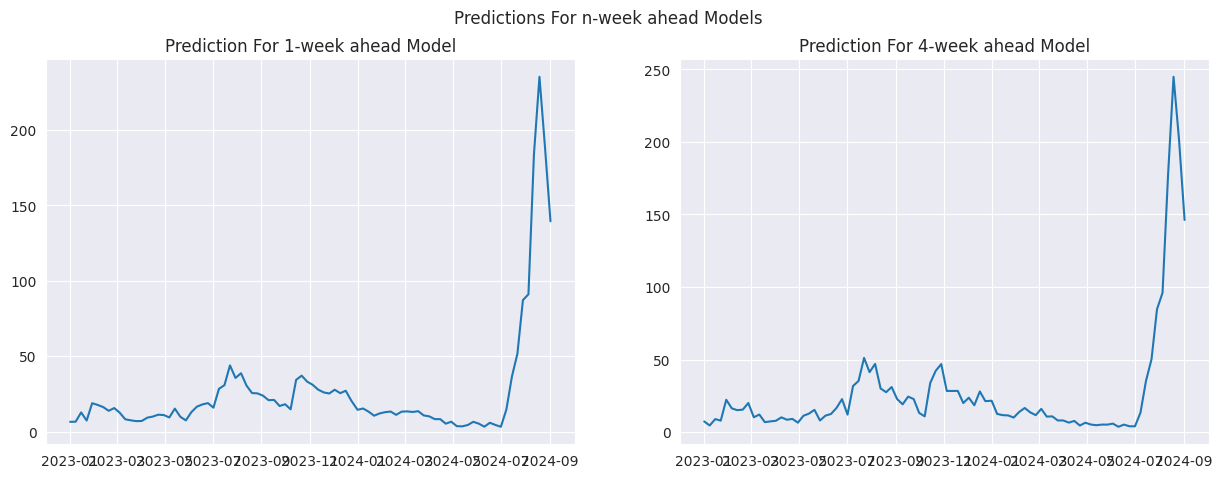

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(date,prediction_1_week)
ax[0].set_title('Prediction For 1-week ahead Model')
ax[1].plot(date,prediction_4_week)
ax[1].set_title('Prediction For 4-week ahead Model')
plt.suptitle('Predictions For n-week ahead Models')
plt.show()

Text(0.5, 1.0, 'Actual Cases')

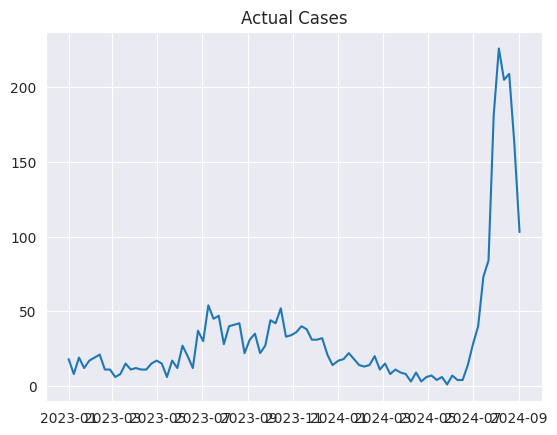

In [42]:
actual_2024 = data[data['date'].dt.year >= 2023]
plt.plot(actual_2024['date'], actual_2024['cases'])
plt.plot()
plt.title('Actual Cases')

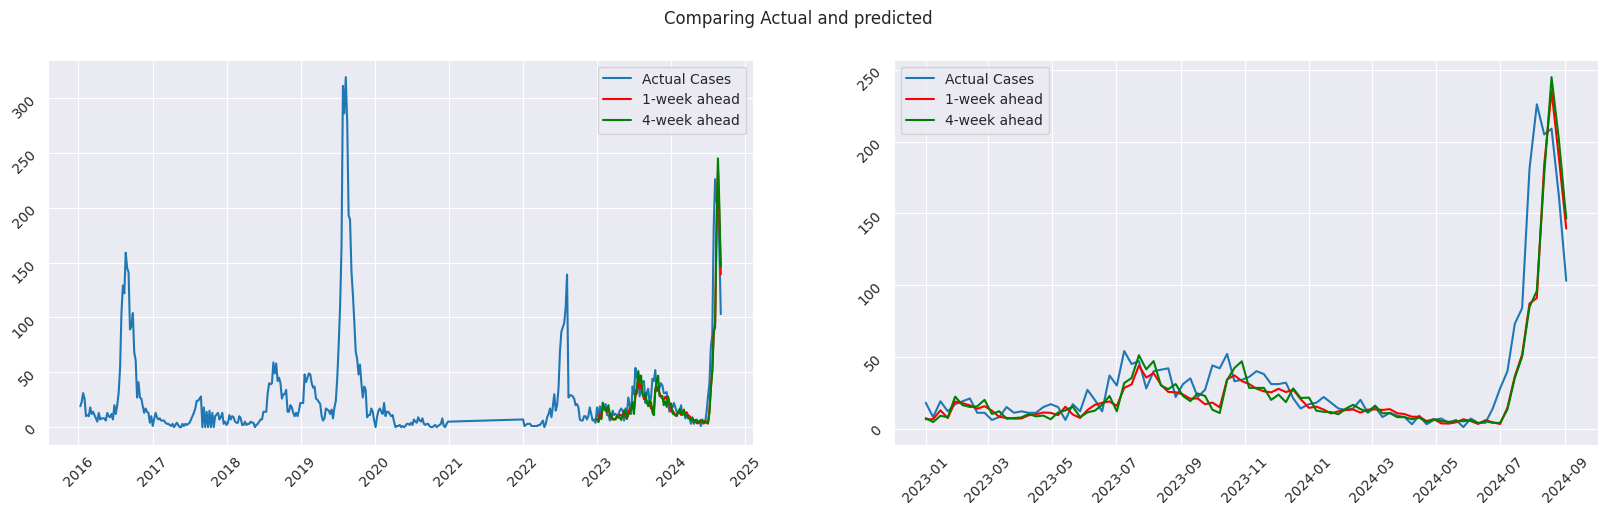

In [43]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(data['date'], data['cases'], label = 'Actual Cases')
ax[0].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[0].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[0].tick_params(labelrotation=45)
ax[0].legend()
ax[1].plot(actual_2024['date'], actual_2024['cases'], label = 'Actual Cases')
ax[1].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[1].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[1].tick_params(labelrotation=45)
ax[1].legend()
plt.suptitle('Comparing Actual and predicted')
plt.show()

In [24]:
torch.cuda.current_device()

0

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda
